##### Section (4.1 Master Dark)

In [170]:
# Importing necessary libraries for all parts of the lab 
import numpy as np
# Provides support for large, multi-dimensional arrays and matrices.
# Useful for mathematical operations such as those needed for constructing master darks, median calculations, and image subtraction.
from scipy import stats
# Help with tasks like calculating the median or other statistical properties of the data.
from astropy.io import fits
# This is used to read and write FITS (Flexible Image Transport System) files, which is the standard format for astronomical data.
# Essential for loading the images, spectra, flat-fields, and dark frames into Python for further analysis.
from astropy.modeling import models, fitting
# Provides a framework for defining models and fitting them to data.
# Useful for tasks like wavelength calibration, where fitting a model to arc lamp spectra is needed.
import matplotlib.pyplot as plt
# A plotting library for creating visualizations such as spectra, fitted curves, and other data representations.
from numpy.polynomial import Polynomial
# Helps with creating and manipulating polynomial functions.
# Useful for tasks like fitting a polynomial to wavelength solutions or correcting for any distortions in the data.
from scipy.signal import find_peaks

In [171]:
# 4.1
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    # Initializes an empty list to store tuples containing the header and data of each FITS file.
    for i in range(start_idx, end_idx + 1):
        # Iterates through the specified range of indices
        file_path = file_template.format(i)
        # Uses the template to create the file path for each FITS file by inserting the current index i into the placeholder.
        with fits.open(file_path) as hdul:
            # Opens the FITS file using astropy.io.fits. The with statement ensures that the file is properly closed after reading.
            # hdul (HDU list) is an object containing all the data and metadata from the FITS file.
            header = hdul[0].header
            # Extracts （提取） the header from the primary HDU (Header Data Unit).
            data = hdul[0].data
            # Extracts the image data from the primary HDU
            frames_info.append((header, data))
            # Adds a tuple containing the header and data of the current FITS file to the frames_info list.
    return frames_info # Returns a list of tuples, where each tuple represents a FITS file’s header and data.

# Allows to load multiple images quickly and efficiently, making it easier to compute the median of a series of images.

In [172]:
def read_calibration_fits(bias_frame_template, bias_frame_start_index, bias_frame_end_index,
                          dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
                          dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
                          light_frame_template, light_frame_start_index, light_frame_end_index,
                          flat_frame_template, flat_frame_start_index, flat_frame_end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames = read_fits_range(bias_frame_template, bias_frame_start_index, bias_frame_end_index)
    dark_frame_light = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
    dark_frame_flat = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)
    light_frame = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
    flat_frame = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

    return bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame

# Templates for the file names

bias_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Bias_Frames_.{:08d}.BIAS.FIT"
dark_frame_light_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_.{:08d}.DARK.FIT"
dark_frame_flat_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
light_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Light_Frames_.{:08d}.FIT"
flat_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Flat_Fields_.{:08d}.FLAT.FIT"


# Define the starting and ending indices


bias_frame_start_index = 0
bias_frame_end_index = 9
dark_frame_light_start_index = 0
dark_frame_light_end_index = 9
dark_frame_flat_start_index = 0
dark_frame_flat_end_index = 9
light_frame_start_index = 0
light_frame_end_index = 240  # For further analysis, ignore frames 67 to 71, and 122
flat_frame_start_index = 8 
flat_frame_end_index = 17




# Calling the function
bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame = read_calibration_fits(
    bias_frame_template, bias_frame_start_index, bias_frame_end_index,
    dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
    dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
    light_frame_template, light_frame_start_index, light_frame_end_index,
    flat_frame_template, flat_frame_start_index, flat_frame_end_index
)


# This function is crucial for the initial data reduction steps:

# Step 1: Reading in dark frames and constructing master darks.
# Step 2: Preparing calibration frames (dark, bias, flat, and arc spectra) for subtraction and correction of science data.
# Step 3: Reading flat fields to create a master flat.
# Step 4: Preparing the arc lamp spectra for wavelength calibration.


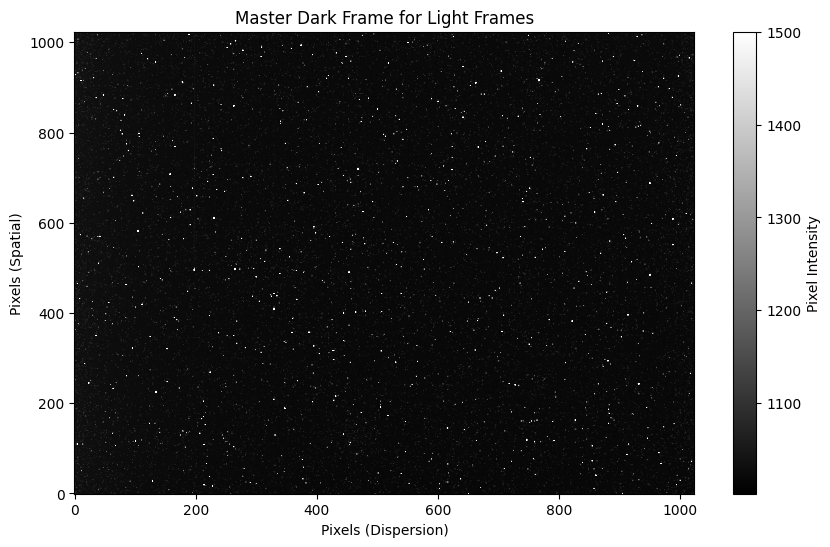

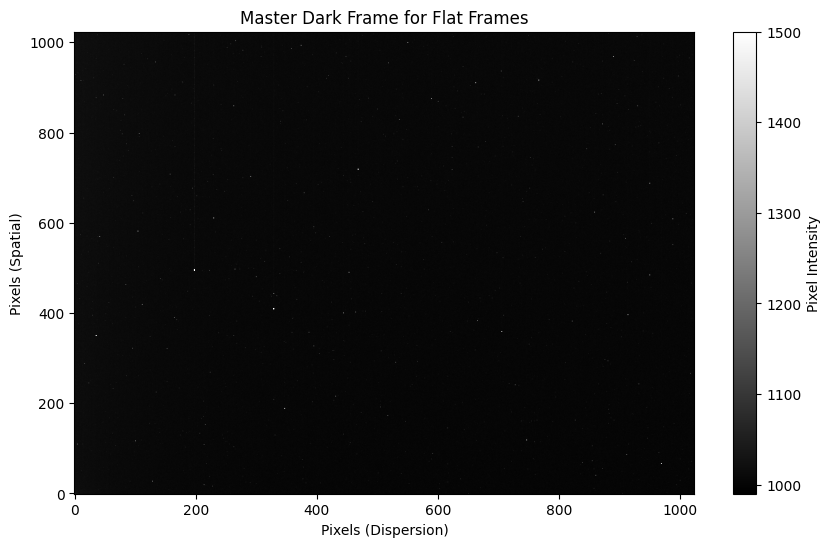

In [173]:
def create_master_dark(dark_frame_light_template, dark_frame_flat_template):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """

    # dark_frames: A list of tuples containing headers and data for each dark frame. 
    # Each tuple has a FITS header and a 2D numpy array (data).
    # Create the master dark frame by median-combining the dark frames
    dark_light_data_list = [frame[1] for frame in dark_frame_light_template]  # Extract the 'data' part from each dark frame
    dark_flat_data_list = [frame[1] for frame in dark_frame_flat_template]
    master_dark_l = np.median(np.stack(dark_light_data_list), axis=0)
    master_dark_f = np.median(np.stack(dark_flat_data_list), axis=0)

    # Extracts the data (2D numpy arrays) from each tuple in dark_frames.
    # Stacks these arrays into a 3D array using np.stack and calculates the median across the stack along the specified axis (axis=0), 
    # which computes the median for each pixel.
    # This process effectively reduces random noise and outliers, such as cosmic ray hits, in the combined master dark frame.

    # Filter the master dark frame
    # master_dark_l[master_dark_l > 9000] = 9000  
    # Clamp values above 9000
    # master_dark_f[master_dark_f > 9000] = 9000
    # Plotting the master dark frame with a maximum value of 9000
    

    # Plotting the master dark for light frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_l, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Light Frames')
    plt.grid(False)
    plt.show()
    
    # Plotting the master dark for flat frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_f, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Flat Frames')
    plt.grid(False)
    plt.show()

    return master_dark_l, master_dark_f


# Example call to the function after loading data correctly

# Load the dark frames using read_fits_range
dark_frame_light = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
dark_frame_flat = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)

master_dark_l, master_dark_f = create_master_dark(dark_frame_light, dark_frame_flat)


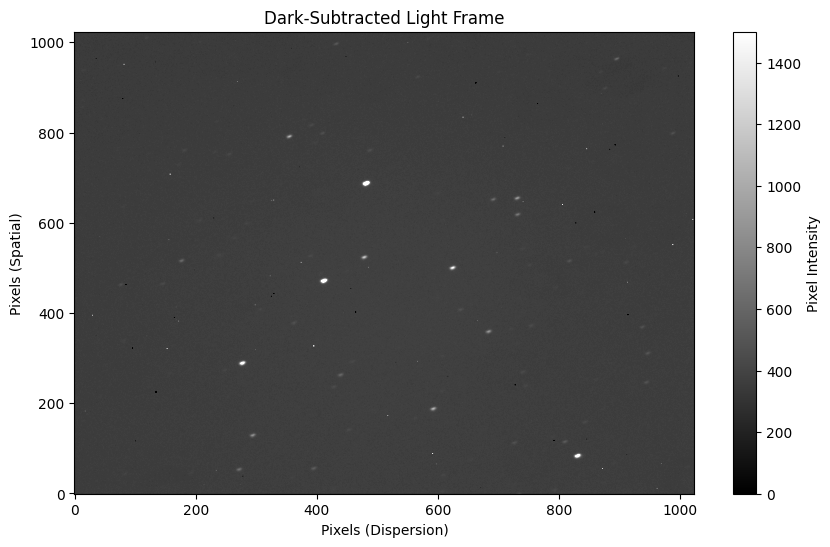

In [174]:
def subtract_master_dark(frames, master_dark):
    """
    Subtract the master dark frame from each frame in a list of FITS frames.

    :param frames: List of tuples containing headers and data for each FITS frame (light or flat frames).
                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type frames: list of tuples
    :param master_dark: Master dark frame to subtract from each frame's data.
    :type master_dark: np.ndarray
    :return: List of tuples with headers and dark-subtracted data for each frame.
    :rtype: list of tuples
    """
    subtracted_frames = []
    for header, data in frames:
        # Perform dark subtraction
        subtracted_data = data - master_dark
        subtracted_frames.append((header, subtracted_data))
    return subtracted_frames

# Load the light and flat frames
light_frames = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
flat_frames = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

# Subtract the master dark frames
light_frames_dark_subtracted = subtract_master_dark(light_frames, master_dark_l)
flat_frames_dark_subtracted = subtract_master_dark(flat_frames, master_dark_f)

# Example: Display one of the dark-subtracted light frames
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_dark_subtracted[0][1], cmap='gray', origin='lower', aspect='auto', vmin=0, vmax =1500)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Light Frame')
plt.grid(False)
plt.show()
